In [53]:
!nvidia-smi

Sat Jan 13 10:16:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0              31W /  70W |   1899MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [54]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [55]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [56]:
from fastbook import *

In [57]:
np.random.seed(5555)

In [58]:
pwd

'/content'

In [59]:
# path =  ("C:\\Users\\Oranuch\\Documents\\Python project\\shoe")
path = ("/content/gdrive/MyDrive/Shoeprint")
path

'/content/gdrive/MyDrive/Shoeprint'

In [60]:
fnames = get_image_files(path)
fnames

(#37) [Path('/content/gdrive/MyDrive/Shoeprint/Nike/N_1.jpg'),Path('/content/gdrive/MyDrive/Shoeprint/Nike/N_2.jpg'),Path('/content/gdrive/MyDrive/Shoeprint/Nike/N_3.jpg'),Path('/content/gdrive/MyDrive/Shoeprint/Nike/N_4.JPG'),Path('/content/gdrive/MyDrive/Shoeprint/Nike/N_5.JPG'),Path('/content/gdrive/MyDrive/Shoeprint/Nike/N_7.JPG'),Path('/content/gdrive/MyDrive/Shoeprint/Nike/N_8.JPG'),Path('/content/gdrive/MyDrive/Shoeprint/Nike/N_9.JPG'),Path('/content/gdrive/MyDrive/Shoeprint/Nike/N_10.JPG'),Path('/content/gdrive/MyDrive/Shoeprint/Nike/N_12.JPG')...]

In [61]:
pat = r"([^/]+)_\d+.*$"
re.findall(pat, str(fnames[0]))

['N']

In [62]:
item_tfms = RandomResizedCrop(460, min_scale=0.8, ratio=(1., 1.))

In [63]:
batch_tfms = [*aug_transforms(size=224, max_warp=0.15), Normalize.from_stats(*imagenet_stats)]

In [64]:
# aug_transforms??
# RandomResizedCrop??

In [65]:
bs = 16

In [66]:
dls = ImageDataLoaders.from_name_re(path, fnames, pat, bs=bs,
                                     batch_tfms=batch_tfms, item_tfms=item_tfms)

In [67]:
# ImageDataLoaders.from_name_re??

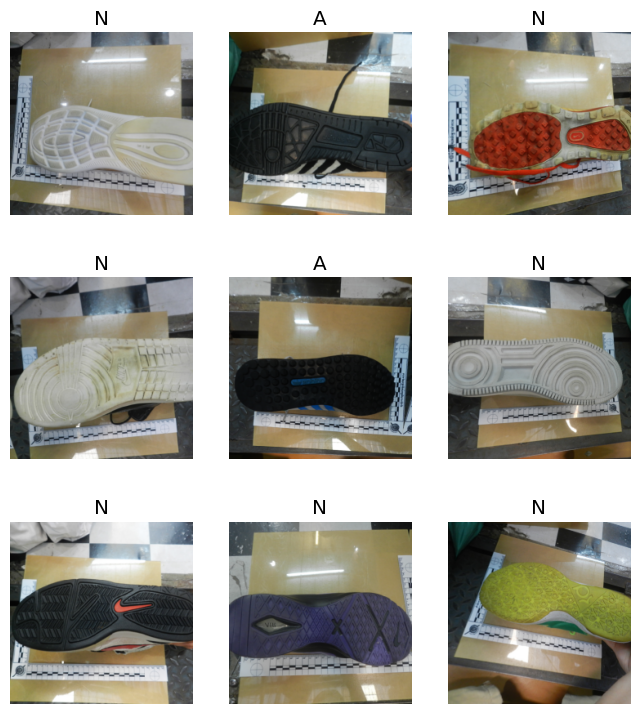

In [68]:
dls.show_batch(max_n=9, figsize=(8, 9))

In [69]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat=r"/([^/]+)_\d+.*"),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [70]:
splitter = RandomSplitter(valid_pct=0.2, seed=5555)
splitter(fnames)

((#30) [32,28,30,29,3,15,33,34,23,1...], (#7) [4,9,21,17,5,35,25])

In [71]:
# path_im = "C:\\Users\\Oranuch\\Documents\\Python project\\shoe"
path_im = path

In [72]:
dls = pets.dataloaders(path_im, bs=bs)

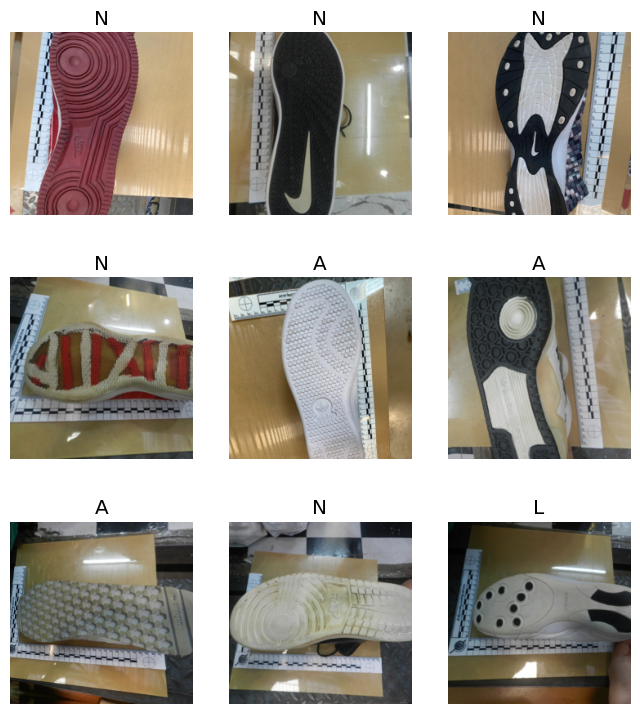

In [73]:
dls.show_batch(max_n=9, figsize=(8, 9))

In [74]:
dls.vocab[2]

'N'

In [75]:
dls.vocab

['A', 'L', 'N']

In [76]:
dls.vocab.o2i.get("Le")

In [77]:
dls.vocab.o2i

{'A': 0, 'L': 1, 'N': 2}

In [78]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=error_rate).to_fp16()

In [79]:
learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,error_rate,time
0,1.946764,1.424830,0.428571,00:07
1,2.087643,1.350690,0.428571,00:06
2,1.858786,1.338270,0.428571,00:08
3,1.887380,1.250123,0.428571,00:06
4,1.961676,1.300154,0.428571,00:11
5,2.005764,1.320968,0.428571,00:06
6,1.942403,1.473327,0.428571,00:07
7,1.844228,1.573081,0.571429,00:06
8,1.803833,1.665306,0.714286,00:07
9,1.789216,1.732579,0.714286,00:06


In [80]:
learn.save("01i-stage1")

Path('models/01i-stage1.pth')

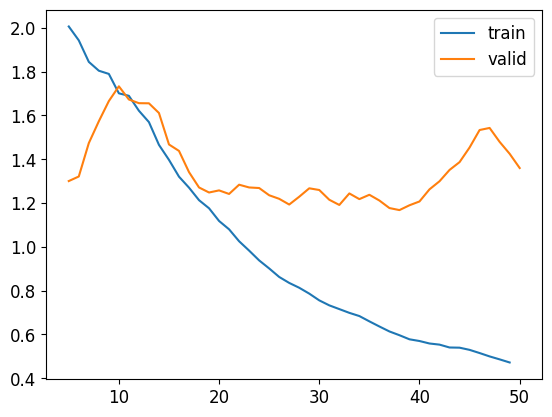

In [81]:
learn.recorder.plot_loss()

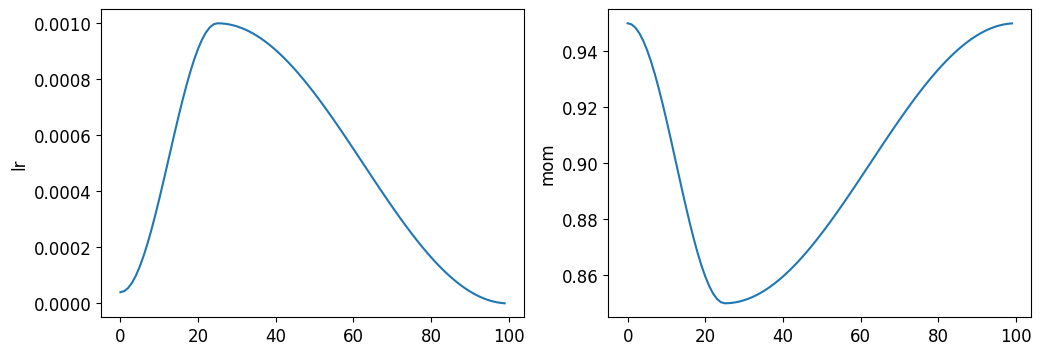

In [34]:
 learn.recorder.plot_sched()

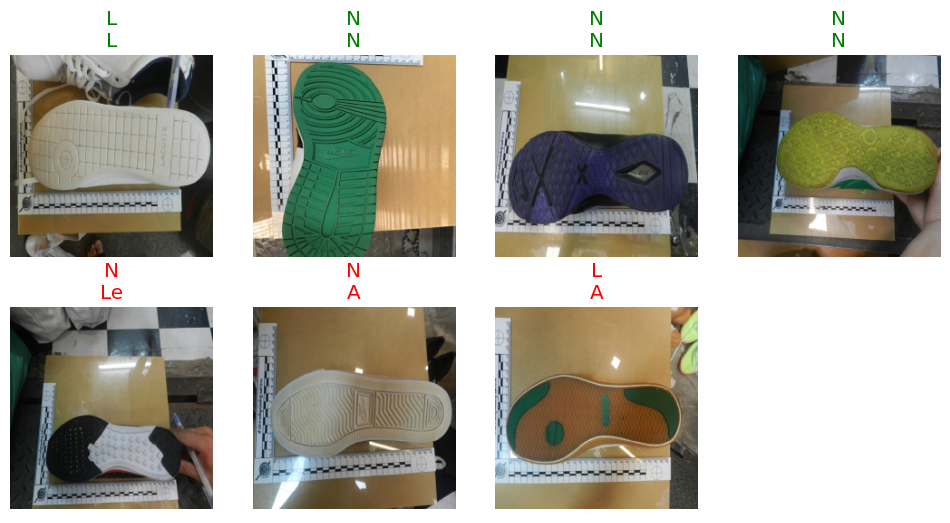

In [35]:
learn.show_results()

In [36]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()

len(dls.valid_ds) == len(losses) == len(idxs)

True

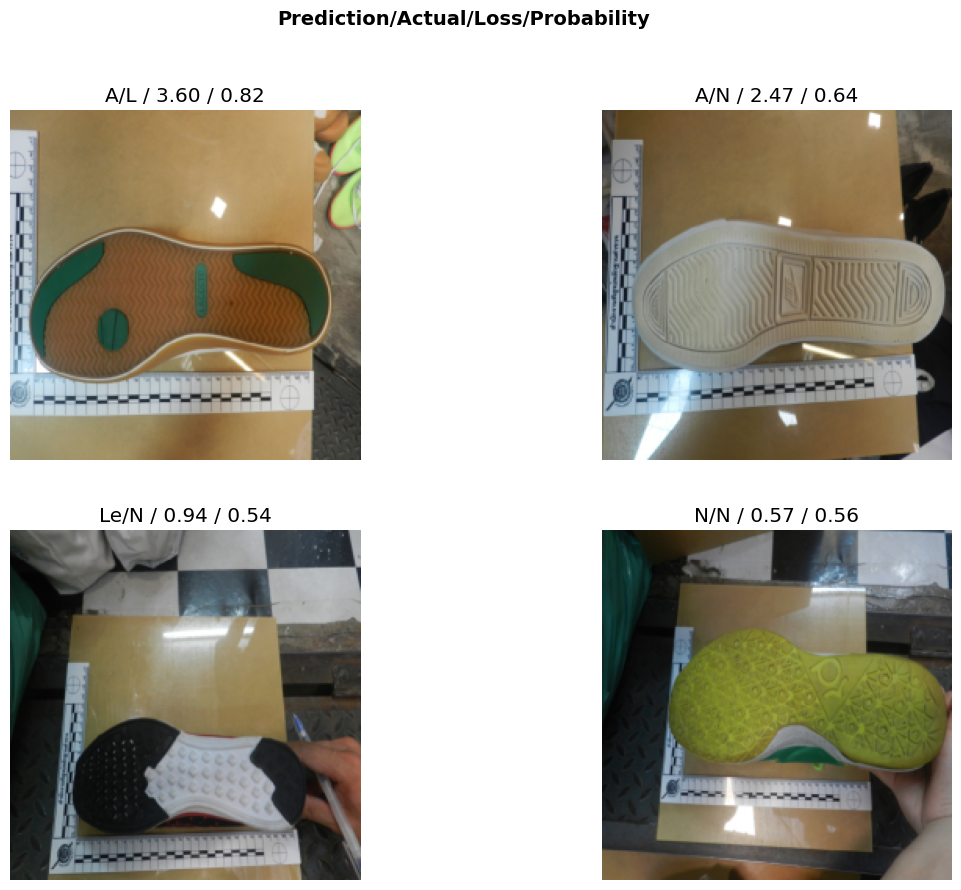

In [37]:
interp.plot_top_losses(4, figsize=(14, 10))

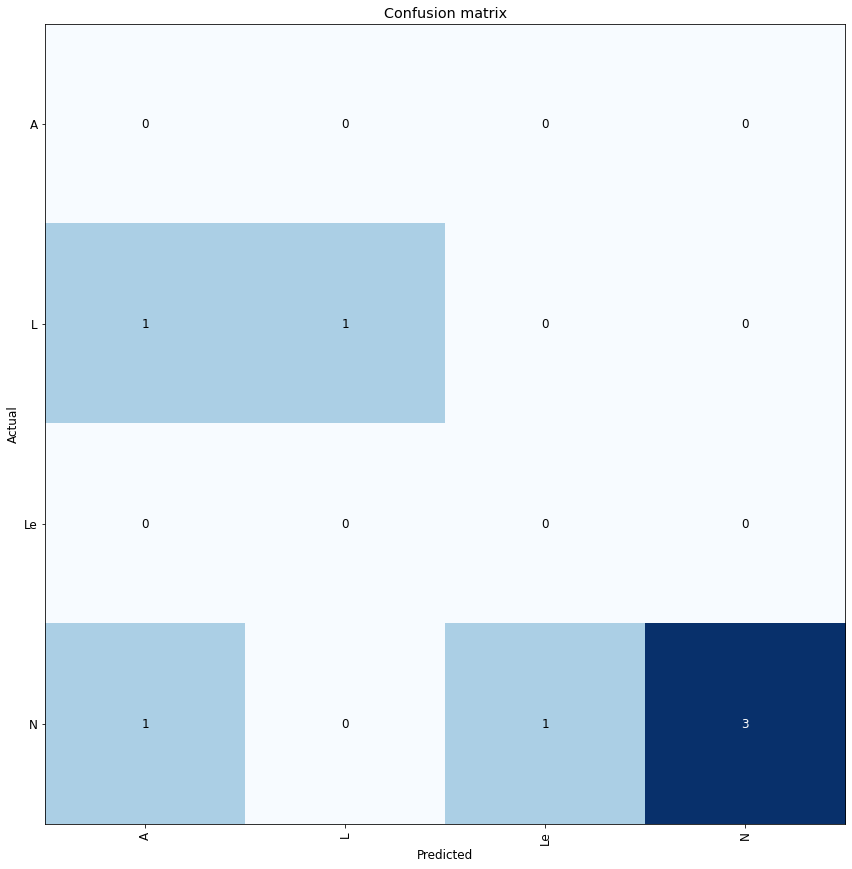

In [39]:
interp.plot_confusion_matrix(figsize=(12, 12), dpi=72)

In [40]:
interp.most_confused(min_val=3)

[]

In [41]:
learn.load("01i-stage1")

In [42]:
learn.unfreeze()

In [43]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.027257,2.557306,0.571429,00:06
1,0.103612,1.662552,0.285714,00:08


In [44]:
learn.load("01i-stage1")

In [45]:
learn.unfreeze()

SuggestedLRs(valley=0.00015848931798245758)

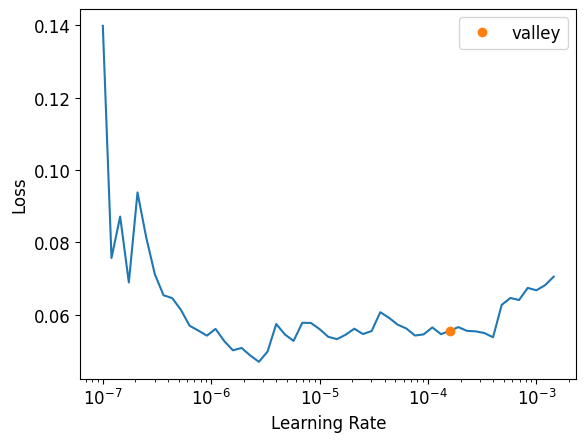

In [46]:
learn.lr_find()

In [47]:
learn.fit_one_cycle(3, lr_max=slice(3e-7, 3e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.076837,1.234812,0.428571,00:05
1,0.071195,1.255596,0.428571,00:06
2,0.080416,1.210315,0.428571,00:06


In [48]:
learn.save('01i-stage2')

Path('models/01i-stage2.pth')

In [49]:
learn = cnn_learner(dls, resnet50, pretrained=True, metrics=error_rate).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 138MB/s]


In [51]:
learn.fine_tune(30)

epoch,train_loss,valid_loss,error_rate,time
0,2.519357,2.519215,0.714286,00:08


epoch,train_loss,valid_loss,error_rate,time
0,1.717539,1.983894,0.571429,00:06
1,1.748199,1.896748,0.571429,00:07
2,1.838910,1.975979,0.714286,00:06
3,1.741594,1.864343,0.714286,00:09
4,1.489779,1.940999,0.714286,00:06
5,1.370006,2.067032,0.714286,00:11
6,1.245832,2.060465,1.000000,00:06
7,1.108443,2.116754,1.000000,00:08
8,0.990651,2.214901,1.000000,00:06
9,0.891209,2.148914,1.000000,00:08
